# Peak Power Prediction 

##### by Winston Chiong

In [192]:
import time 
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px 

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## Data Cleaning & Visualization  

Let's see what our dataset looks like.

In [193]:
original = pd.read_csv("slrpEV11052020-09222022.csv")
pd.set_option('display.max_columns' , None)
original.head()

,dcosId,userId,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,Duration,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate
0,24,605,500e,6600,23,7,2020-11-05T10:30:16,2020-11-05T10:31:09,NaN,NaN,5.35224,130.0,9.0,15.0,200.0,0 days 03:43:57,3.73249,REGULAR,1,0,3281.0,6335,"[{'power_W': Decimal('6259'), 'timestamp': Dec...",2020-11-05T14:15:06
1,26,486,Model 3,24000,23,3,2020-11-11T07:39:55,2020-11-11T07:39:59,NaN,NaN,10.75291,150.0,3.0,15.0,200.0,0 days 06:50:07,6.83527,REGULAR,1,0,33458.0,7005,"[{'power_W': Decimal('0'), 'timestamp': Decima...",2020-11-11T14:30:06
2,30,620,Volt,3600,25,12,2020-11-13T16:19:55,2020-11-13T16:20:06,2020-11-14T04:15:00,18400.0,29.32211,180.0,3.0,12.0,300.0,0 days 20:40:02,20.66722,SCHEDULED,0,1,15216.0,3450,"[{'power_W': Decimal('0'), 'timestamp': Decima...",2020-11-14T13:00:08
3,31,618,Bolt EV,7200,23,6,2020-11-14T23:47:06,2020-11-14T23:47:16,NaN,NaN,3.82125,150.0,3.0,18.0,400.0,0 days 02:12:51,2.21416,REGULAR,1,0,14378.0,6889,"[{'power_W': Decimal('6889'), 'timestamp': Dec...",2020-11-15T02:00:07
4,32,623,B-Class Electric Drive,6000,23,9,2020-11-16T11:38:44,2020-11-16T11:42:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 03:12:45,3.21249,REGULAR,1,0,12484.0,6852,"[{'power_W': Decimal('6813'), 'timestamp': Dec...",2020-11-16T14:55:07


### Extracting Power and Time

Our main column of concern is the column labeled `power`, where each row represents power usage by a unique user, and the nested structure shows power (Watts) at a particular point in time (represented in Unix time).

Here's what the first record looks like.

In [194]:
original["power"][0]

"[{'power_W': Decimal('6259'), 'timestamp': Decimal('1604601308')}, {'power_W': Decimal('6269'), 'timestamp': Decimal('1604601606')}, {'power_W': Decimal('6298'), 'timestamp': Decimal('1604601906')}, {'power_W': Decimal('6318'), 'timestamp': Decimal('1604602206')}, {'power_W': Decimal('6335'), 'timestamp': Decimal('1604602506')}, {'power_W': Decimal('5809'), 'timestamp': Decimal('1604602806')}, {'power_W': Decimal('3589'), 'timestamp': Decimal('1604603106')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604603406')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604603706')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604604011')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604604306')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604604606')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604604906')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604605206')}, {'power_W': Decimal('0'), 'timestamp': Decimal('1604605506')}, {'power_W': Decimal('0'), 'times

Each instance is enclosed by curly braces and separated by commas.

Let's unnest the data and clean it up:

1. Pattern match `[{'power_W': Decimal('`, `{'power_W': Decimal('`, `')`, `'timestamp': Decimal('`, `')}`, and `')}]`. That way, we're left with strings, in alternating power and UNIX time.
2. Split our string on each `, ` delimiter and cast our `str` values to `int` values. 

In [195]:
#1
pattern = r"(\[?\{'power_W':\sDecimal\(')|('timestamp':\sDecimal\(')|('\)\}?\]?)"
power_and_time = original["power"].str.replace(pattern , "" , regex = True) # remove all pattern instances 

#2
power_and_time = power_and_time.str.split(', ')
power_and_time = power_and_time.apply(lambda lst : [int(val) for val in lst]) # cast all str value to int

power_and_time

0       [6259, 1604601308, 6269, 1604601606, 6298, 160...
1       [0, 1605109206, 6978, 1605109506, 6987, 160510...
2       [0, 1605313212, 3425, 1605313507, 3426, 160531...
3       [6889, 1605426607, 6873, 1605426907, 6867, 160...
4       [6813, 1605555907, 6822, 1605556207, 6821, 160...
                              ...                        
2054    [3327, 1661173813, 2921, 1661174108, 2874, 166...
2055    [4155, 1661178618, 6233, 1661178907, 6237, 166...
2056    [6625, 1661194208, 6628, 1661194507, 6624, 166...
2057    [0, 1661197808, 6670, 1661198107, 6622, 166119...
2058    [6, 1661202907, 3327, 1661203207, 3327, 166120...
Name: power, Length: 2059, dtype: object

Notice that power values start at index 0, and occurs every other value. Time values start at index 1, and similarly occurs every other value. We can easily extract separate power and time Series objects through slicing.


In [196]:
power_vals = power_and_time.apply(lambda x : x[::2])
time_vals = power_and_time.apply(lambda x : x[1::2])

Since our power and time Series objects are nested, we can call the `.explode()` method to unnest our data.

In [197]:
power_vals = power_vals.explode()
time_vals = time_vals.explode()

[UNIX time](https://en.wikipedia.org/wiki/Unix_time) is a system for describing a point in time. It is the number of seconds that have elapsed since the Unix epoch, excluding leap seconds. The Unix epoch is 00:00:00 UTC on 1 January 1970 (an arbitrary date). 

UNIX time is a little hard to interpret, so let's convert UNIX time to a human-readable datetime.

Let's define a function that does the following : 
1. Some of our UNIX time aren't exactly 5 minutes apart, so let's round every UNIX time value up 5 minutes. We can do this as such:
    * ```time_vals = time_vals // (5 * 60) * (5*60) + (5*60)``` 
    * We round down the number of 5 minute intervals (UNIX time is now divisible by 300 seconds), convert back to UNIX time, then add 5 minutes.  
2. Convert UNIX time to the form ```year-month-day hour:minute```, Pacific Standard Time.

In [198]:
def round_format_UNIX_time(time_value):
    """Function takes in a UNIX time value, and rounds this value up 5 minutes.
    The time value is then converted into the format year-month-day hour:minute."""
    
    # round time up 5 minutes 
    time_value = time_value // (5 * 60) * (5*60) + (5*60)
    
    # format time value
    time_value = time.strftime('%Y-%m-%d %H:%M', time.localtime(time_value))
    
    return time_value 


Let's apply our function to every value in our `time_vals` Series object.

In [199]:
time_vals = time_vals.apply(round_format_UNIX_time)
time_vals

0       2020-11-05 10:40
0       2020-11-05 10:45
0       2020-11-05 10:50
0       2020-11-05 10:55
0       2020-11-05 11:00
              ...       
2058    2022-08-22 16:55
2058    2022-08-22 17:00
2058    2022-08-22 17:05
2058    2022-08-22 17:10
2058    2022-08-22 17:15
Name: power, Length: 112684, dtype: object

Let's create a temporary dataframe from our power and time values and join this with our original dataframe.

In [200]:
temp_df = pd.DataFrame({"time" : time_vals , "power_5m" : power_vals}) 
df = original.join(temp_df)
df.head()

,dcosId,userId,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,Duration,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate,time,power_5m
0,24,605,500e,6600,23,7,2020-11-05T10:30:16,2020-11-05T10:31:09,NaN,NaN,5.35224,130.0,9.0,15.0,200.0,0 days 03:43:57,3.73249,REGULAR,1,0,3281.0,6335,"[{'power_W': Decimal('6259'), 'timestamp': Dec...",2020-11-05T14:15:06,2020-11-05 10:40,6259
0,24,605,500e,6600,23,7,2020-11-05T10:30:16,2020-11-05T10:31:09,NaN,NaN,5.35224,130.0,9.0,15.0,200.0,0 days 03:43:57,3.73249,REGULAR,1,0,3281.0,6335,"[{'power_W': Decimal('6259'), 'timestamp': Dec...",2020-11-05T14:15:06,2020-11-05 10:45,6269
0,24,605,500e,6600,23,7,2020-11-05T10:30:16,2020-11-05T10:31:09,NaN,NaN,5.35224,130.0,9.0,15.0,200.0,0 days 03:43:57,3.73249,REGULAR,1,0,3281.0,6335,"[{'power_W': Decimal('6259'), 'timestamp': Dec...",2020-11-05T14:15:06,2020-11-05 10:50,6298
0,24,605,500e,6600,23,7,2020-11-05T10:30:16,2020-11-05T10:31:09,NaN,NaN,5.35224,130.0,9.0,15.0,200.0,0 days 03:43:57,3.73249,REGULAR,1,0,3281.0,6335,"[{'power_W': Decimal('6259'), 'timestamp': Dec...",2020-11-05T14:15:06,2020-11-05 10:55,6318
0,24,605,500e,6600,23,7,2020-11-05T10:30:16,2020-11-05T10:31:09,NaN,NaN,5.35224,130.0,9.0,15.0,200.0,0 days 03:43:57,3.73249,REGULAR,1,0,3281.0,6335,"[{'power_W': Decimal('6259'), 'timestamp': Dec...",2020-11-05T14:15:06,2020-11-05 11:00,6335


From the master dataframe, let's extract and power and time from a sub dataframe.

Multiple users can be charging their EV's at the same time, so let's sum power values if they occur at the same time. Let's also sort our time values. 

In [201]:
df_power_time = df[["time" , "power_5m"]]
df_power_time = df_power_time.groupby("time").agg(sum)
df_power_time = df_power_time.sort_values(by = "time")
df_power_time.head()

,power_5m
time,
2020-11-05 10:40,6259
2020-11-05 10:45,6269
2020-11-05 10:50,6298
2020-11-05 10:55,6318
2020-11-05 11:00,6335


### Upsampling Time Series

If no one is recorded charging their EV, there shouldn't be any power consumption. If we were to line plot our data right now, data points would be linearly interpolated, which doesn't reflect reality. 

Our time stamps are recorded at irregular intervals. Let's upsample our time series to fill gaps where `power` should be zero. 

We can do this in two steps :
1. Convert our ```time_vals``` column to datatime objects (which pandas can resample).
2. We can resample our datetime index into 5 minute bins. We can call ```sum()``` on our sample object, as ```NaN``` sums to zero. 

In [202]:
df_power_time.index = pd.to_datetime(df_power_time.index)

df_power_time = df_power_time.resample("5min").sum()
df_power_time

,power_5m
time,
2020-11-05 10:40:00,6259
2020-11-05 10:45:00,6269
2020-11-05 10:50:00,6298
2020-11-05 10:55:00,6318
2020-11-05 11:00:00,6335
...,...
2022-08-22 16:55:00,0
2022-08-22 17:00:00,0
2022-08-22 17:05:00,0


### Calendar Variables

It might be helpful to append our dataframe with one-hot encoded calendar features, for example, $X_{monday} = 1$ if Monday, $X_{monday} = 0$ if not. 

In [203]:
from sklearn.preprocessing import OneHotEncoder

# add a new column with the name of the day of the week 
df_power_time["day"] = df_power_time.index.day_name()

def ohe_day_name(data):
    """This function takes in dataframe with a column 'day', which consists of the name of the day of the week, and one-hot encodes
    the day of the week."""
    oh_enc = OneHotEncoder()
    temp = pd.DataFrame(oh_enc.fit_transform(data[["day"]]).toarray() , columns = oh_enc.get_feature_names_out() , index = df_power_time.index)
    return pd.concat([df_power_time , temp] , axis = 1)

df_power_time = ohe_day_name(df_power_time)

# rename and reorder columns 
df_power_time.rename(columns = {"day_Friday":"Friday", "day_Monday":"Monday",
                                                "day_Saturday":"Saturday", "day_Sunday":"Sunday" ,
                                                "day_Thursday":"Thursday", "day_Tuesday":"Tuesday",
                                                "day_Wednesday":"Wednesday"} , inplace = True)
df_power_time = df_power_time[["power_5m", "day", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday" , "Sunday"]]

df_power_time.head()

,power_5m,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
time,,,,,,,,,
2020-11-05 10:40:00,6259,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-11-05 10:45:00,6269,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-11-05 10:50:00,6298,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-11-05 10:55:00,6318,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-11-05 11:00:00,6335,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We can do the same for other calendar variables, such as school vacations, holidays, etc. 

**List of Exogenous Calendar Variables :**

| Calendar Variables |
|--------------------|
| Monday             |
| Tuesday            |
| Wednesday          |
| Thursday           |
| Friday             |
| Saturday           |
| Sunday             |
| Summer Break       |
| Winter Break       |
| Spring Break       |
| Thanksgiving Break |      
| Federal Holiday    |

Note that UC Berkeley's summer, winter, spring, and Thanksgiving break will need to be hardcoded, as I can't find a structured way to pull them through Python. 

In [204]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# import federal holidays calendar 
calendar = USFederalHolidayCalendar() 
holidays = calendar.holidays(start=df_power_time.index[0], end=df_power_time.index[-1])

# round index to midnight, compare to holidays index, and cast Boolean values to binary   
df_power_time["Federal Holiday"] = df_power_time.index.normalize().isin(holidays)
df_power_time["Federal Holiday"]  = df_power_time["Federal Holiday"].astype(int)
df_power_time

,power_5m,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Federal Holiday
time,,,,,,,,,,
2020-11-05 10:40:00,6259,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2020-11-05 10:45:00,6269,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2020-11-05 10:50:00,6298,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2020-11-05 10:55:00,6318,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2020-11-05 11:00:00,6335,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2022-08-22 16:55:00,0,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-08-22 17:00:00,0,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-08-22 17:05:00,0,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [205]:
print(f"Start record: {df_power_time.index[0]} | End record: {df_power_time.index[-1]}")

Start record: 2020-11-05 10:40:00 | End record: 2022-08-22 17:15:00


From the eye test, it looks like we'll need 2020 Thanksgiving Break + Winter Break, 2021 Spring Break + Summer Break + Winter Break, and 2022 Spring Break + Summer Break.

In [206]:
# Convention: 
# Start: Monday after break 
# Stop: day before start of instruction 
academic_breaks_ranges = [["2020-11-26" , "2020-11-27"] , ["2020-12-21" , "2021-01-11"] , ["2021-03-22" , "2021-03-28"] , ["2021-05-17" , "2021-08-17"] ,
                   ["2021-12-20" , "2022-01-10"] , ["2022-03-21" , "2022-03-27"] , ["2022-05-16" , "2022-08-16"]]

In [207]:
# Can't create empty DateTimeIndex object; manually add first entries 
academic_breaks = pd.date_range(academic_breaks_ranges[0][0] , academic_breaks_ranges[0][1]) 

# append date ranges to DateTimeIndex object
for break_range in academic_breaks_ranges[1:] :
    academic_breaks = academic_breaks.union(pd.date_range(break_range[0] , break_range[1]))
academic_breaks

DatetimeIndex(['2020-11-26', '2020-11-27', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26',
               '2020-12-27', '2020-12-28',
               ...
               '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14',
               '2022-08-15', '2022-08-16'],
              dtype='datetime64[ns]', length=246, freq=None)

In [208]:
# round index to midnight, compare to academic break index, and cast Boolean values to binary   
df_power_time["Academic Break"] = df_power_time.index.normalize().isin(academic_breaks)
df_power_time["Academic Break"]  = df_power_time["Academic Break"].astype(int)
df_power_time

,power_5m,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Federal Holiday,Academic Break
time,,,,,,,,,,,
2020-11-05 10:40:00,6259,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
2020-11-05 10:45:00,6269,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
2020-11-05 10:50:00,6298,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
2020-11-05 10:55:00,6318,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
2020-11-05 11:00:00,6335,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-22 16:55:00,0,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2022-08-22 17:00:00,0,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2022-08-22 17:05:00,0,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


### Instantaneous Number of Users 

Another feature that might be helpful would be the number of connected users at any given point in time. 

In [209]:
df_users = df[["userId" , "time"]]
df_users.head()

,userId,time
0,605,2020-11-05 10:40
0,605,2020-11-05 10:45
0,605,2020-11-05 10:50
0,605,2020-11-05 10:55
0,605,2020-11-05 11:00


Let's group by time and aggregate by count of users. Then, we can upsample our time index to match the 5-minute bins of `df_power_time`.

In [210]:
df_users = df_users.groupby("time").agg("count")
# upsample into 5-minute bins 
df_users.index = pd.to_datetime(df_users.index)
df_users = df_users.resample("5min").sum()
df_users

,userId
time,
2020-11-05 10:40:00,1
2020-11-05 10:45:00,1
2020-11-05 10:50:00,1
2020-11-05 10:55:00,1
2020-11-05 11:00:00,1
...,...
2022-08-22 16:55:00,2
2022-08-22 17:00:00,2
2022-08-22 17:05:00,2


Let's rename the `userId` column and join our `df_users` dataframe with our `df_power_time` dataframe.

In [211]:
df_users.rename(columns = {'userId':'Connected Users'}, inplace = True)
df_power_time = df_power_time.join(df_users)
df_power_time.head()

,power_5m,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Federal Holiday,Academic Break,Connected Users
time,,,,,,,,,,,,
2020-11-05 10:40:00,6259,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 10:45:00,6269,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 10:50:00,6298,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 10:55:00,6318,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 11:00:00,6335,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1


### Visualization

In [212]:
import plotly.graph_objs as go
from plotly_resampler import FigureResampler

#### Number of Users Connected

In [213]:
# Use library plotly_resampler to generative an interactive plot without lag 
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(), hf_x = df_power_time.index , hf_y = df_power_time["Connected Users"])

# title and axes labels
fig.update_layout(title="Number of Users Connected", xaxis_title="Time", yaxis_title="Count")

fig.show_dash(mode='inline')

#### 5-Minute Aggregate Power

In [214]:
df_power_time[["power_5m"]]

,power_5m
time,
2020-11-05 10:40:00,6259
2020-11-05 10:45:00,6269
2020-11-05 10:50:00,6298
2020-11-05 10:55:00,6318
2020-11-05 11:00:00,6335
...,...
2022-08-22 16:55:00,0
2022-08-22 17:00:00,0
2022-08-22 17:05:00,0


In [215]:
# Use library plotly_resampler to generative an interactive plot without lag 
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(), hf_x = df_power_time.index , hf_y = df_power_time["power_5m"])

# title and axes labels
fig.update_layout(title="5 Min Aggregate Power", xaxis_title="Time", yaxis_title="Power (W)")

fig.show_dash(mode='inline')

It might help to define a function that allows us to plot individual months in our dataframe.

In [216]:
def plot_monthly_power(month , year) :
    """Function takes in a month and year, and generates the 5-minute aggregate
    power plot for that month and year. An empty plot signifies no data for that month and year."""
    if month == 12 :
        month_df = df_power_time.loc[(df_power_time.index >= f"{year}-{month}-01") \
                                     & (df_power_time.index < f"{year + 1}-01-01")] # go to January 
    else : 
        month_df = df_power_time.loc[(df_power_time.index >= f"{year}-{month}-01") \
                                     & (df_power_time.index < f"{year}-{month + 1}-01")]
    
    fig = px.line(month_df , x = month_df.index , y = "power_5m")
    fig.update_layout(title=f"5 Min Aggregate Power -- {month}/{year}", xaxis_title="Time", yaxis_title="Power (W)")
    fig.show()

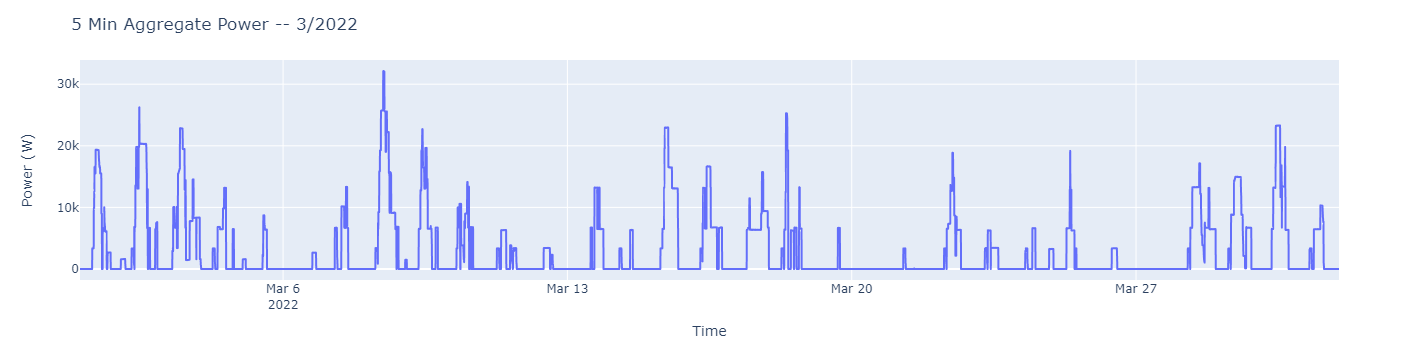

In [217]:
plot_monthly_power(3 , 2022)

#### Collinearity 

As a sanity check, let's examine the collinearity between the number of users and 5-minute aggregate power. We should expect the aggregate power to scale linearly with the number of connected users.

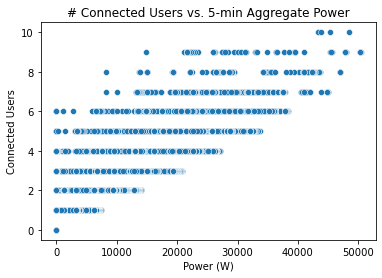

Correlation : 0.9088363418864


In [218]:
sns.scatterplot(data = df_power_time , x = "power_5m" , y = "Connected Users")
plt.title("# Connected Users vs. 5-min Aggregate Power")
plt.xlabel("Power (W)")
plt.show()
print(f'Correlation : {np.corrcoef(df_power_time["power_5m"] , df_power_time["Connected Users"])[0][1]}')

***

## Time Series Analysis 

### Exploration

#### Granularity Adjustment

For the purposes of time series analysis, a 24-hour peak power granularity might work better; as it stands, 5-minute aggregate power is very sparse, with about only 26% non-zero values. 

In [365]:
print(f'Proportion of Non-Zero Time Series Elements: \
{np.count_nonzero(df_power_time["power_5m"]) / len(df_power_time["power_5m"])}')
df_power_time.head()

Proportion of Non-Zero Time Series Elements: 0.271513353115727


,power_5m,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Federal Holiday,Academic Break,Connected Users
time,,,,,,,,,,,,
2020-11-05 10:40:00,6259,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 10:45:00,6269,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 10:50:00,6298,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 10:55:00,6318,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-05 11:00:00,6335,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1


Peak power by day strikes a good balance with low sparsity while maintaining a healthy amount of data points. However, trends throughout the day will be lost. 

Let's resample our time series by day and since we are trying to predict peak power demand, let's also call ```max()``` as our aggregation function. Note that the one-hot encoded calendar variables are the same for each unique day, so ```max()``` will return the correct value.

In [366]:
df_24h = df_power_time.resample("24h").max()
df_24h.rename(columns = {"power_5m" : "max_power"} , inplace = True)
print(f'Proportion of Non-Zero Time Series Elements: \
{np.count_nonzero(df_24h["max_power"]) / len(df_24h["max_power"])}')
df_24h.head()

Proportion of Non-Zero Time Series Elements: 0.801829268292683


,max_power,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Federal Holiday,Academic Break,Connected Users
time,,,,,,,,,,,,
2020-11-05,6335,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1
2020-11-06,0,Friday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
2020-11-07,0,Saturday,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
2020-11-08,0,Sunday,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
2020-11-09,0,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


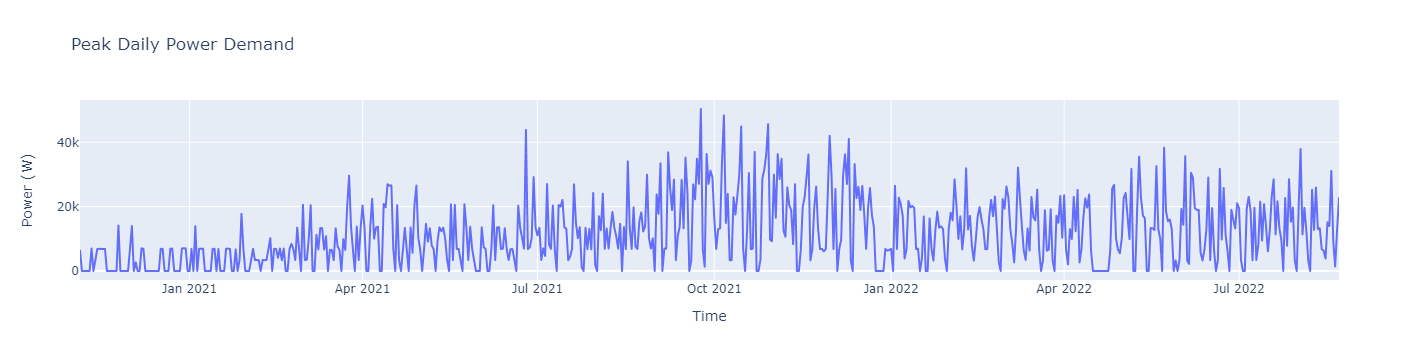

In [367]:
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(), hf_x = df_24h.index  , hf_y = df_24h["max_power"])
fig.update_layout(title = f"Peak Daily Power Demand", xaxis_title = "Time", yaxis_title="Power (W)")
fig.show()

#### Feature Engineering

As a simple feature we can add in a previous 7-day rolling average.

In [368]:
df_24h["rollingavg7"] = df_24h["max_power"].shift(1).rolling(7).mean()

#### Date Adjustment

Additionally, we can see that from about early November to the start of March, there appears to be a very low power demand. This can most likely be attributed to the COVID-19 pandemic and the fact that SLRPeV had just been installed. Since pandemic effects have drastically decreased, it may be worthwhile to remove trends/patterns no longer exhibited by our data. We also get an improvement in non-zero entries.

In [369]:
df_24h_ts = df_24h.loc[(df_24h.index >= "2021-03-01") , :]
print(f'Proportion of Non-Zero Time Series Elements: \
{np.count_nonzero(df_24h_ts["max_power"]) / len(df_24h_ts["max_power"])}')
df_24h_ts.head()

Proportion of Non-Zero Time Series Elements: 0.8666666666666667


,max_power,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Federal Holiday,Academic Break,Connected Users,rollingavg7
time,,,,,,,,,,,,,
2021-03-01,20547,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,6524.285714
2021-03-02,3393,Tuesday,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,8482.428571
2021-03-03,3531,Wednesday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,2,7757.285714
2021-03-04,10039,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,3,7283.428571
2021-03-05,20453,Friday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,4,8228.857143


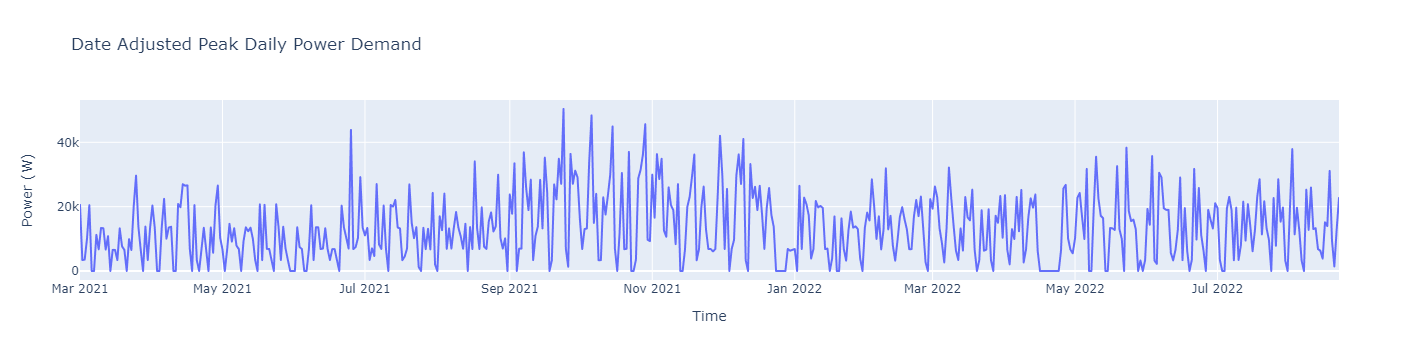

In [410]:
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(), hf_x = df_24h_ts.index  , hf_y = df_24h_ts["max_power"])
fig.update_layout(title = f"Date Adjusted Peak Daily Power Demand", xaxis_title = "Time", yaxis_title="Power (W)")
fig.show()

#### Seasonality 

By intuition, we would expect weekends to exhibit a lower maximum power demand than weekdays. Taking the mean of weekday and weekend maximum power demand shows this to be true. 

In [411]:
weekends_mean = df_24h_ts[(df_24h_ts["Saturday"] == 1) | (df_24h_ts["Sunday"] == 1)]["max_power"].mean()
weekdays_mean = df_24h_ts[~(df_24h_ts["Saturday"] == 1) & ~(df_24h_ts["Sunday"] == 1)]["max_power"].mean()
print(f"Weekday Mean Power : {weekdays_mean} \nWeekend Mean Power : {weekends_mean}")

Weekday Mean Power : 16971.901554404147 
Weekend Mean Power : 4197.448051948052


For further inspection, let's also plot by the mean max power demand for each day of the week.

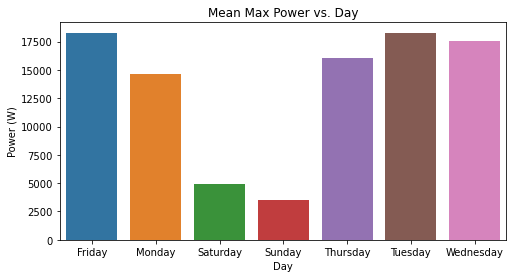

In [412]:
mean_power_day = df_24h_ts[["day", "max_power"]].groupby("day").mean()
plt.figure(figsize = (8,4))
sns.barplot(data = mean_power_day , x = mean_power_day.index , y = mean_power_day["max_power"])
plt.title("Mean Max Power vs. Day")
plt.ylabel("Power (W)")
plt.xlabel("Day")
plt.show()

Plotting the ACF also shows spikes at lags of multiples of 7. Clearly, weekly seasonality is present.

In [373]:
import statsmodels.api as sm 

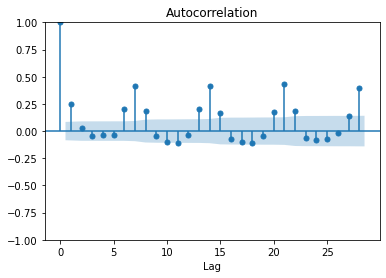

In [374]:
sm.graphics.tsa.plot_acf(df_24h_ts["max_power"])
plt.xlabel("Lag")
plt.show()

#### Distribution of Values

The empirical distribution for peak daily power is right tailed, while the empirical distributoin for weekly peak power is fairly symmetrical. 

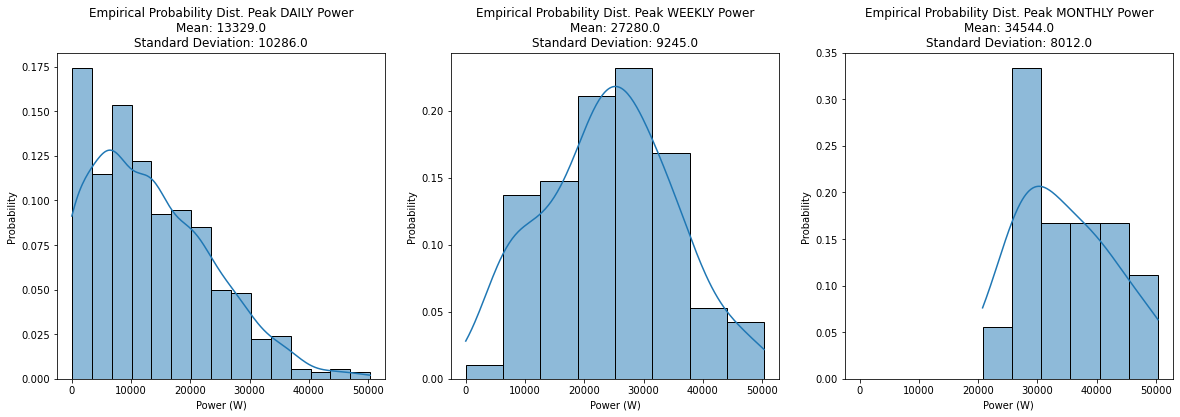

In [375]:
fig , ax = plt.subplots(1 , 3 , sharex = "all") # share axes
fig.set_size_inches(20, 6)

plt.subplot(1, 3 , 1)
sns.histplot(df_24h_ts["max_power"] , stat = 'probability' , kde = True)
plt.xlabel("Power (W)")
plt.title(f'Empirical Probability Dist. Peak DAILY Power\nMean: {np.round(np.mean(df_24h_ts["max_power"]))}\
\nStandard Deviation: {np.round(np.std(df_24h_ts["max_power"]))}')

plt.subplot(1,3,2)
sns.histplot(df_24h["max_power"].resample("1W").max() , stat = 'probability' ,  kde = True)
plt.xlabel("Power (W)")
plt.title(f'Empirical Probability Dist. Peak WEEKLY Power\nMean: {np.round(np.mean(df_24h_ts["max_power"].resample("1W").max()))}\
\nStandard Deviation: {np.round(np.std(df_24h_ts["max_power"].resample("1W").max()))}')

plt.subplot(1,3,3)
sns.histplot(df_24h_ts["max_power"].resample("1M").max() , stat = 'probability' ,  kde = True)
plt.xlabel("Power (W)")
plt.title(f'Empirical Probability Dist. Peak MONTHLY Power\nMean: {np.round(np.mean(df_24h_ts["max_power"].resample("1M").max()))}\
\nStandard Deviation: {np.round(np.std(df_24h_ts["max_power"].resample("1M").max()))}')

plt.show()

### Time Series Decomposition

One classical method of time series analysis is time series decomposition. Our time series is broken down into three components: trend, seasonality, and random noise. Here, we use the additive model : 

$Y_t = S_t + T_t + E_t$ 

Where $T_t$ represents trend in our time series, $S_t$ represents seasonality in our time series, and $E_t$ represents our residual, or random error.

We can use the ```tsa.seasonal_decompose``` method in the ```statsmodels``` library to break down our time series into the above decomposition. ```statsmodels``` uses moving averages to decompose time series. See [appendix](#Appendix) for more information.

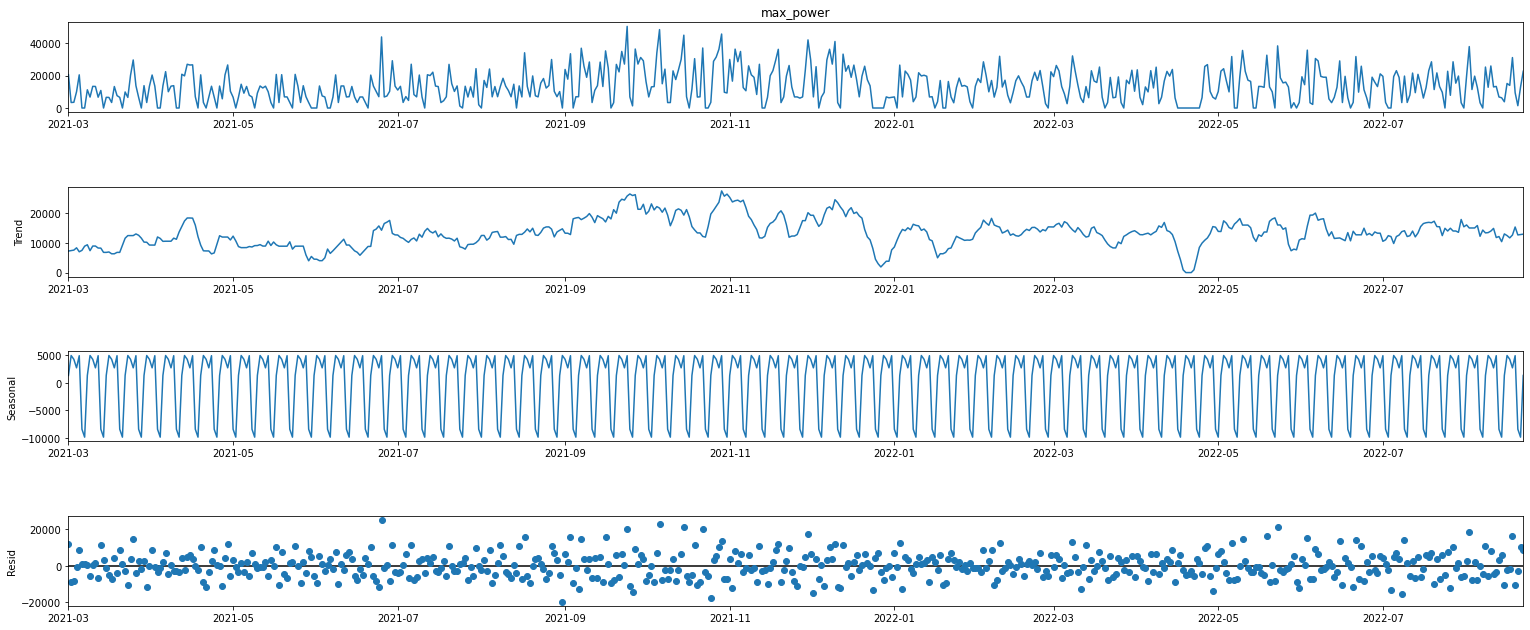

In [376]:
decomposed = sm.tsa.seasonal_decompose(x = df_24h_ts["max_power"] , model = 'additive' , period = 7 , extrapolate_trend = 'freq')
fig = decomposed.plot() # y-axis is in the same units as original time series, Power (W)
fig.set_size_inches(25, 10)
plt.show()

#### Residuals

Let's take a closer look at the residuals, which ideally, should be normally distributed, with $\mu = 0$, finite variance, and serially uncorrelated. This particular combination is known as Gaussian White Noise. The PACF and ACF plots of the residuals should show no significant spikes.

Mean: 27.86054264006228


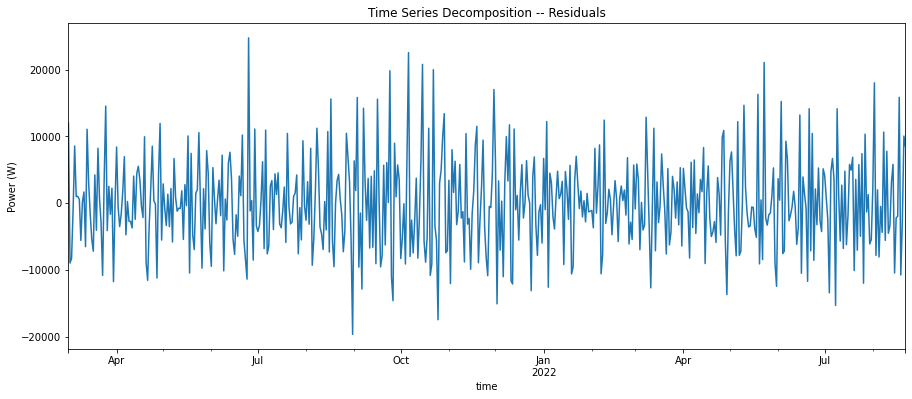

In [377]:
decomposed.resid.plot(figsize = (15, 6))
plt.ylabel("Power (W)")
plt.title("Time Series Decomposition -- Residuals")
print("Mean:" , np.mean(decomposed.resid))
plt.show()

The residuals do display some significant auto- and partial autocorrelations, indicating our residuals may not be perfectly Gaussian White Noise.

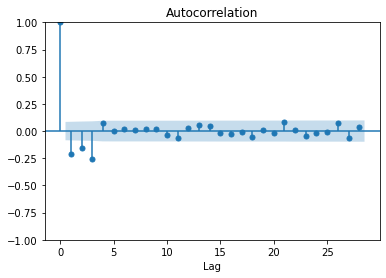

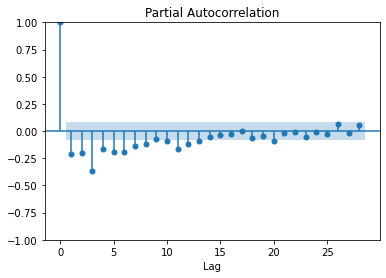

In [378]:
sm.graphics.tsa.plot_acf(decomposed.resid)
plt.xlabel("Lag")
plt.show()
sm.graphics.tsa.plot_pacf(decomposed.resid, method = "ywm")
plt.xlabel("Lag")
plt.show()

The residuals do look normally distributed. For further inspection, let's overlay the empiral histogram against a theoretical 0-mean normal distribution.   

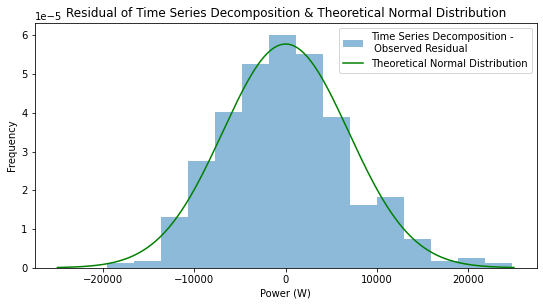

In [379]:
import scipy.stats as stats

x_array = np.arange(-25000, 25000, 1)
y_array_normal = stats.norm.pdf(x_array , 0 , np.std(decomposed.resid))

fig , _ = plt.subplots()
fig.set_size_inches(9, 4.5)

decomposed.resid.plot(kind = 'hist' , density = True, bins = 15, label = "Time Series Decomposition - \n Observed Residual", alpha = 0.5)
sns.lineplot(x = x_array, y = y_array_normal , color = "green", label = "Theoretical Normal Distribution")

plt.legend(loc = "upper right")
plt.xlabel("Power (W)")
plt.title("Residual of Time Series Decomposition & Theoretical Normal Distribution")
plt.show()

### SARIMA-X

(Seasonal Auto-Regressive Integrated Moving Average + Exogenous Variables)

#### Stationarity 

A key first step in applying classical time series models is to transform our data to achieve stationarity. Stationarity is defined as a constant mean and (finite) variance over time. 

##### Differencing

Our data is weekly seasonal, so it is important to remove this seasonality before preceding. One method to remove seasonality is differencing, where each datapoint is subtracted from its last seasonal datapoint. Formally :

$Y_t^{'} = Y_t - Y_{t-7}$

Each datapoint is the difference between that day and the previous week's same day. Note that we will have 7 fewer datapoints in the differenced time series, as we cannot calculate a difference for the first 7 observations.


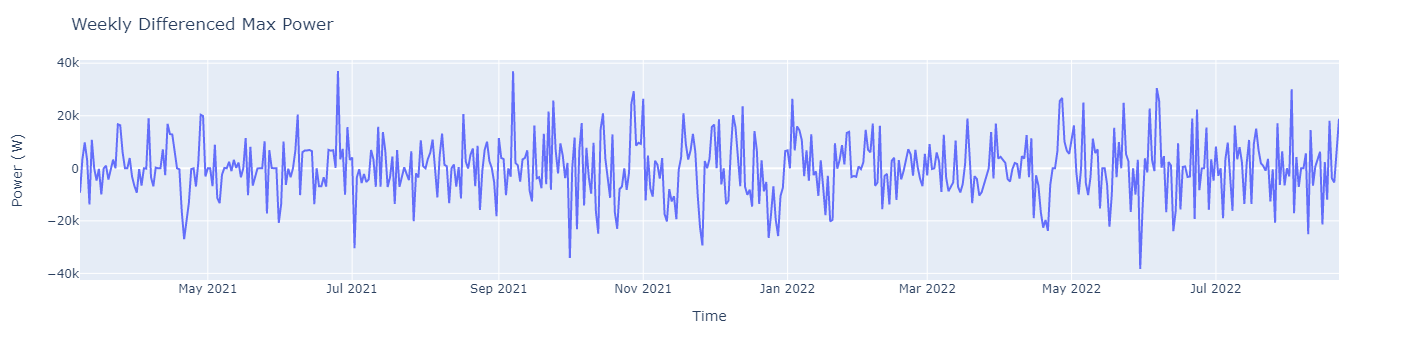

In [380]:
fig = px.line(data_frame = df_24h_ts["max_power"], x = df_24h_ts["max_power"].diff(periods = 7).dropna().index, 
              y = df_24h_ts["max_power"].diff(periods = 7).dropna())
fig.update_layout(title = "Weekly Differenced Max Power", xaxis_title = "Time", yaxis_title = "Power (W)")
fig.show()

We can robustly check for stationarity using an Augmented Dickey-Fuller test. A negative test statistic and low p-value corresponds to a high probability that our time series is not stationarity.

In [381]:
adf_result = sm.tsa.stattools.adfuller(df_24h_ts["max_power"].diff(periods = 7).dropna())
print(f"Augmented Dickey-Fuller Test Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")      

Augmented Dickey-Fuller Test Statistic: -10.401676285591869
p-value: 1.902287341844144e-18


#### Autocorrelation Analysis

Autocorrelation function (ACF) and partial autocorrelation function (PACF) plots determine the parameters of an ARIMA model.

Let's plot the ACF and PACF of our time series.

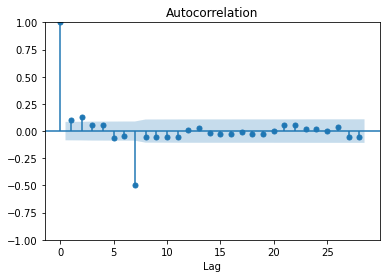

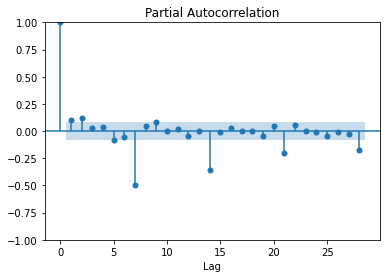

In [382]:
sm.graphics.tsa.plot_acf(df_24h_ts["max_power"].diff(periods = 7).dropna())
plt.xlabel("Lag")
plt.show()
sm.graphics.tsa.plot_pacf(df_24h_ts["max_power"].diff(periods = 7).dropna() , method = "ywm")
plt.xlabel("Lag")
plt.show()

#### Train & Test Split

Let's split our dataset into a training set and test set, withholding 20% of our data. To maintain the temporality of our data, we'll use the first 80% of our data to train, using the last 20% to evaluate our model.

In [383]:
# from sklearn.model_selection import train_test_split
train = df_24h_ts[:int(0.8*len(df_24h_ts)):]
test = df_24h_ts[int(0.8*len(df_24h_ts))::]

#### Optimal SARIMA-X Parameters

Normally, the optimal SARIMA-X order and seasonal order ($p$, $q$, $P$, and $Q$) are found by looking for patterns in the ACF and PACF plots. However, we can use the ```pmdarima``` library's ```auto_arima``` to grid search for the optimal parameters.

In [385]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(train["max_power"], start_p = 0, start_q = 0, max_p = 3, max_q = 3, max_Q = 3, max_P = 3, 
                             d = 0, D = None, m = 7, 
                             X = train[["Academic Break" , "Federal Holiday" , "rollingavg7"]],
                             seasonal = True, trace = True , stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=9055.266, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=9191.029, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=9137.001, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=9152.460, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=11382.521, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=9165.239, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=9149.083, Time=0.09 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=9054.854, Time=0.26 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=9116.290, Time=0.18 sec
 ARIMA(0,0,0)(3,0,1)[7] intercept   : AIC=9050.970, Time=0.82 sec
 ARIMA(0,0,0)(3,0,0)[7] intercept   : AIC=9075.731, Time=0.44 sec
 ARIMA(0,0,0)(3,0,2)[7] intercept   : AIC=9050.132, Time=1.23 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(3,0,3)[7] intercept   : AIC=9047.442, Time=2.96 sec
 ARIMA(0,0,0)(2,0,3)[7] intercept   :

With the optimal parameters, we can fit an SARIMA model to our training data, and additionally passing in ```Academic Break``` and ```Federal Holiday``` as exogenous variables.

In [413]:
best_model_arima = sm.tsa.arima.ARIMA(train["max_power"], order = stepwise_fit.order, seasonal_order = stepwise_fit.seasonal_order,
                                      exog = train[["Academic Break" , "Federal Holiday","rollingavg7"]])
fitted = best_model_arima.fit()

#### Classical

Here, we plot the in-sample SARIMA forecast as well as the out-of-sample prediction, overlaid on the true data. We can see the out-of-sample prediction converges to the sample mean for long forecasting periods, which is typical for SARIMA models and regression models in general; the model just doesn't "know" what will happen that far in the future, and in long-term forecasting, the average becomes the best estimate. Unfortunately, this fails to capture that high variance that our original data is capable of.

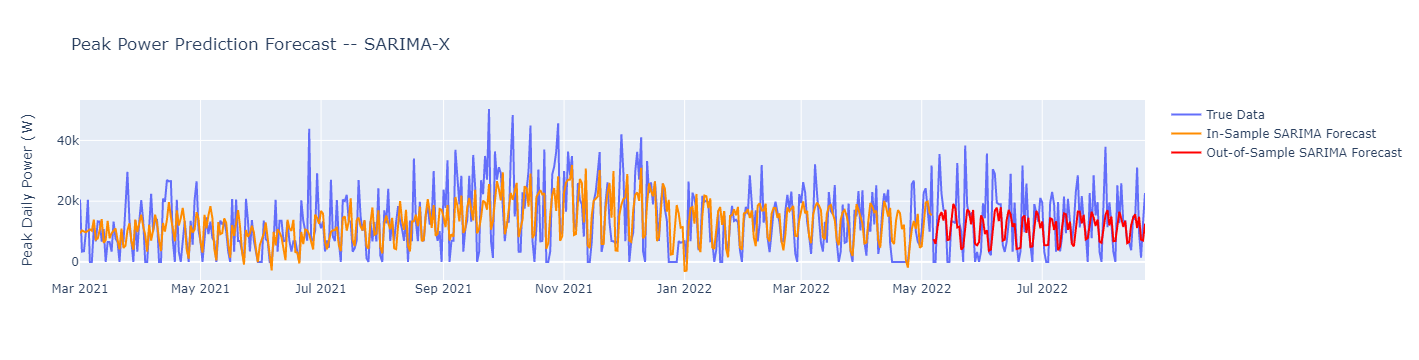

Test Set RMSE: 8746.789800041715 Watts


In [414]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x = df_24h_ts["max_power"].index , y = df_24h_ts["max_power"], name = "True Data")
)
fig.add_trace(
    go.Scatter(x = fitted.predict().index, y = fitted.predict() , name = "In-Sample SARIMA Forecast" , line= {"color":"#FF8C00"})
)
fig.add_trace(
    go.Scatter(x = fitted.predict(start = test.index[0] , end = test.index[len(test) - 1], exog = test[["Academic Break" , "Federal Holiday","rollingavg7"]]).index, 
               y = fitted.predict(start = test.index[0] , end = test.index[len(test) - 1], exog = test[["Academic Break" , "Federal Holiday","rollingavg7"]]),  
               name = "Out-of-Sample SARIMA Forecast" , line= {"color":"Red"})
)
fig.update_layout({"title" : "Peak Power Prediction Forecast -- SARIMA-X" , "yaxis_title" : "Peak Daily Power (W)"})
fig.show()
print('Test Set RMSE:', 
      np.sqrt(np.mean((test["max_power"] - fitted.predict(start = test.index[0] , end = test.index[len(test) - 1], exog = test[["Academic Break" , "Federal Holiday","rollingavg7"]]))**2)),
     'Watts')

##### Residuals

ACF and PACF of the residuals.

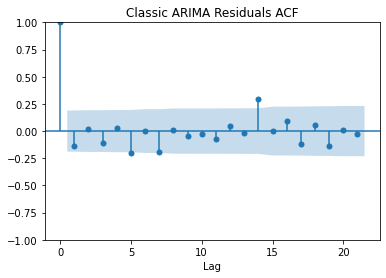

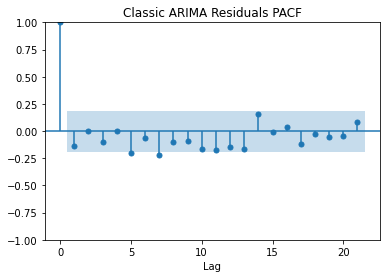

In [415]:
sm.graphics.tsa.plot_acf(test["max_power"] - fitted.predict(start = test.index[0] , end = test.index[len(test) - 1], exog = test[["Academic Break" , "Federal Holiday","rollingavg7"]]))
plt.xlabel("Lag")
plt.title("Classic ARIMA Residuals ACF")
plt.show()

sm.graphics.tsa.plot_pacf(test["max_power"] - fitted.predict(start = test.index[0] , end = test.index[len(test) - 1], exog = test[["Academic Break" , "Federal Holiday","rollingavg7"]]) , method = "ywm")
plt.xlabel("Lag")
plt.title("Classic ARIMA Residuals PACF")
plt.show()

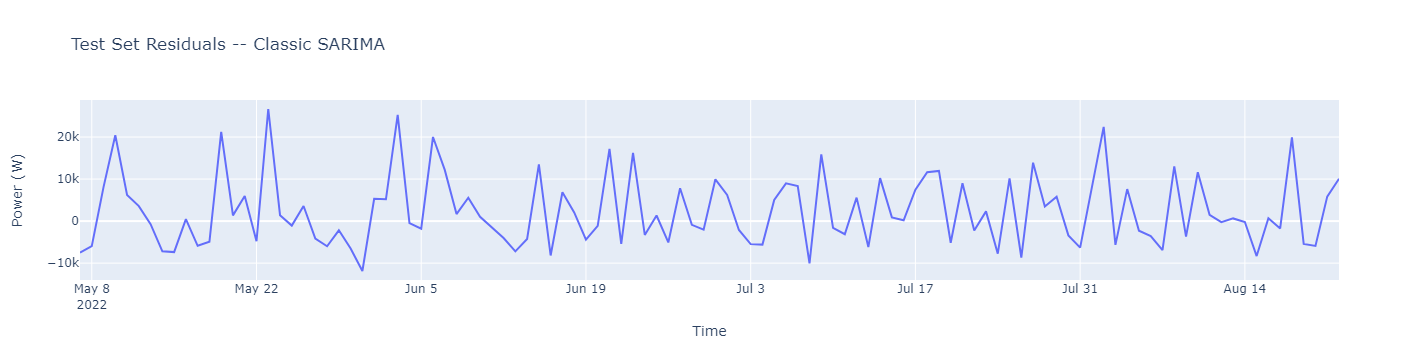

Residual Mean: 2321.1224237832735


In [416]:
residuals_df_ts = test["max_power"] - fitted.predict(start = test.index[0] , end = test.index[len(test) - 1], exog = test[["Academic Break" , "Federal Holiday","rollingavg7"]])

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = residuals_df_ts.index,
               y = residuals_df_ts)
)
fig.update_layout(title = "Test Set Residuals -- Classic SARIMA", xaxis_title = "Time", yaxis_title = "Power (W)")
fig.show()
print("Residual Mean:",
      np.mean(residuals_df_ts))

#### Rolling Forecast Origin

One alternative to avoid the convergence of SARIMA models is to use a rolling forecast origin. The idea is to only predict one period in the future (as opposed to predicting the entire values of our test set). After predicting a value, we use the true value to refit a model to predict the next value.

For example, 
we can train on days $1,2,\ldots,k-3$ to predict day $k-2$,

train on days $1,2,\ldots,k-3,k-2$ to predict day $k-1$ (taking into account the true value for day $k-2$),

and train on days $1,2,\ldots,k-3,k-2,k-1$ to predict day $k$ (taking into account the true values for days $k-2$ and $k-1$).

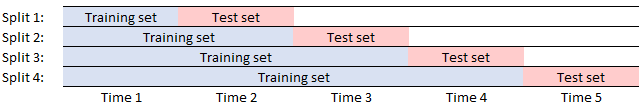


In [417]:
# this cell takes 90 seconds to run

from datetime import timedelta 

rolling_predictions = pd.Series(dtype = float)
for train_end in test.index:
    train_data = df_24h_ts[:train_end-timedelta(days=1)]
    model = sm.tsa.arima.ARIMA(train_data["max_power"], order = stepwise_fit.order, seasonal_order = stepwise_fit.seasonal_order,
                              exog = train_data[["Academic Break" , "Federal Holiday","rollingavg7"]])
    model_fit = model.fit()
    
    # predict a single value
    pred = model_fit.forecast(exog = test[["Academic Break" , "Federal Holiday","rollingavg7"]].loc[(test.index == train_end)])
    rolling_predictions = pd.concat([rolling_predictions , pred])
    
rolling_predictions

2022-05-07     7491.863773
2022-05-08     5940.689032
2022-05-09    11318.759066
2022-05-10    15118.261728
2022-05-11    16849.832622
                  ...     
2022-08-18    16877.397117
2022-08-19    15686.177371
2022-08-20     7260.537853
2022-08-21     3340.325247
2022-08-22    17780.195477
Freq: 24H, Length: 108, dtype: float64

We do get a greater variance in our predictions, but it still doesn't always capture the peaks in our data. 

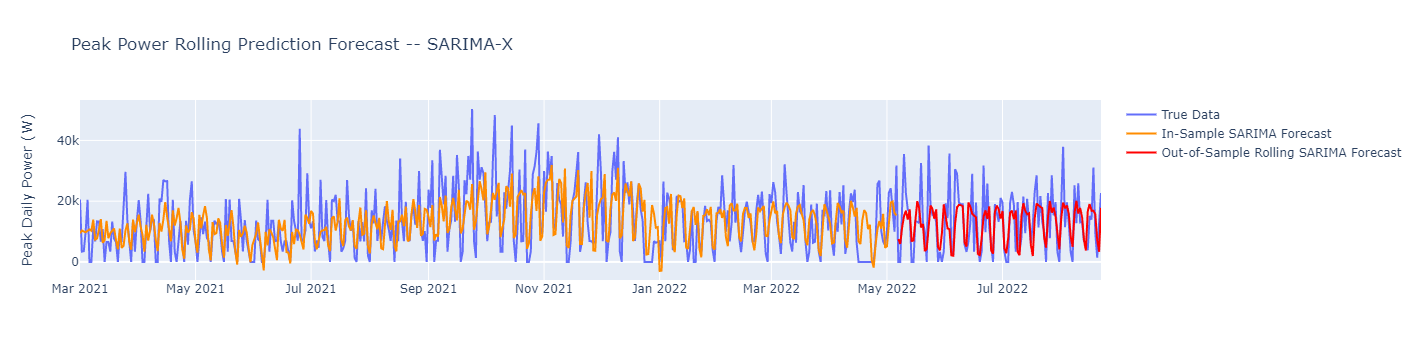

Test Set RMSE: 8346.658197883069 Watts


In [418]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x = df_24h_ts["max_power"].index , y = df_24h_ts["max_power"], name = "True Data")
)
fig.add_trace(
    go.Scatter(x = fitted.predict().index, y = fitted.predict() , name = "In-Sample SARIMA Forecast" , line= {"color":"#FF8C00"})
)
fig.add_trace(
    go.Scatter(x = rolling_predictions.index,
               y = rolling_predictions , name = "Out-of-Sample Rolling SARIMA Forecast" , line= {"color":"Red"})
)
fig.update_layout({"title" : "Peak Power Rolling Prediction Forecast -- SARIMA-X" , "yaxis_title" : "Peak Daily Power (W)"})
fig.show()
print(f'Test Set RMSE: {np.sqrt(np.mean((test["max_power"] - rolling_predictions)**2))} Watts')

##### Residuals

ACF and PACF of residuals (rolling forecast origin). 

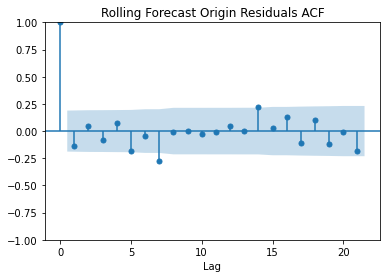

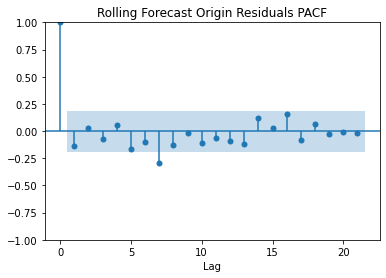

In [419]:
sm.graphics.tsa.plot_acf(test["max_power"] - rolling_predictions)
plt.xlabel("Lag")
plt.title("Rolling Forecast Origin Residuals ACF")
plt.show()

sm.graphics.tsa.plot_pacf(test["max_power"] - rolling_predictions , method = "ywm")
plt.xlabel("Lag")
plt.title("Rolling Forecast Origin Residuals PACF")
plt.show()

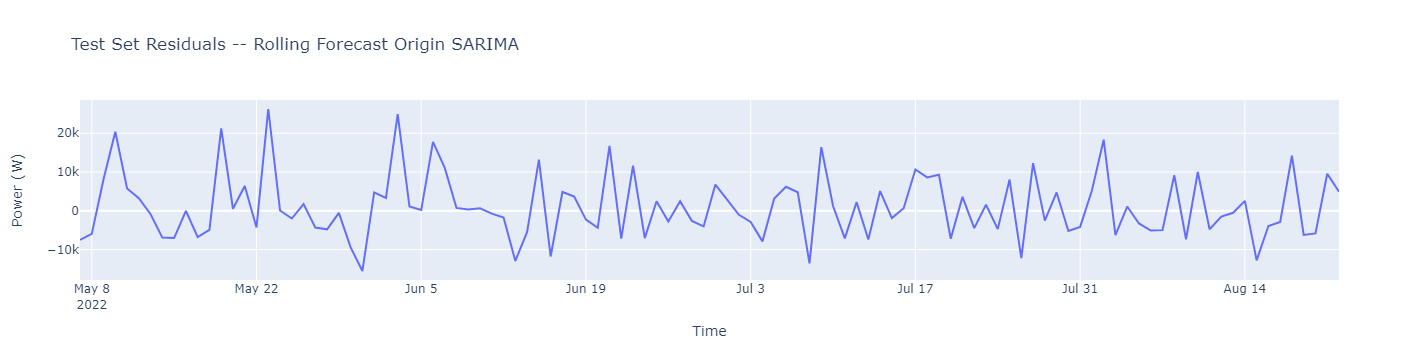

Residual Mean: 979.3401260685687
Residual STD: 8289.004523449159


In [420]:
residuals_df_ts = test["max_power"] - rolling_predictions

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = residuals_df_ts.index,
               y = residuals_df_ts)
)
fig.update_layout(title = "Test Set Residuals -- Rolling Forecast Origin SARIMA", xaxis_title = "Time", yaxis_title = "Power (W)")
fig.show()
print("Residual Mean:", np.mean(residuals_df_ts))
print("Residual STD:", np.std(residuals_df_ts))

## Regression Trees

To use regression trees, our dataframe must be in a format that can be used by decision trees. Each record (row) should contain all the desired features we wish to train our tree on, whereas previously, with time series analysis, past realized values were used as explanatory variables.

We can start off simple, and use the previous day's value, previous week's day's value, and a previous 7 day rolling average as features. Similarly with time series analysis, we can remove COVD-era dates.

In [403]:
df_24h_tree = df_24h.copy(deep = True)
df_24h_tree["lag1"] = df_24h_tree["max_power"].shift(1)
df_24h_tree["lag2"] = df_24h_tree["max_power"].shift(2)
df_24h_tree["lag7"] = df_24h_tree["max_power"].shift(7)
df_24h_tree["rollingavg7"] = df_24h_tree["max_power"].shift(1).rolling(7).mean()
df_24h_tree = df_24h_tree.loc[(df_24h_tree.index >= "2021-03-01") , :]
df_24h_tree.head(10)

,max_power,day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Federal Holiday,Academic Break,Connected Users,rollingavg7,lag1,lag2,lag7
time,,,,,,,,,,,,,,,,
2021-03-01,20547,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,6524.285714,0.0,6607.0,6840.0
2021-03-02,3393,Tuesday,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,8482.428571,20547.0,0.0,8469.0
2021-03-03,3531,Wednesday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,2,7757.285714,3393.0,20547.0,6848.0
2021-03-04,10039,Thursday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,3,7283.428571,3531.0,3393.0,3421.0
2021-03-05,20453,Friday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,4,8228.857143,10039.0,3531.0,13485.0
2021-03-06,0,Saturday,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,9224.285714,20453.0,10039.0,6607.0
2021-03-07,0,Sunday,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,8280.428571,0.0,20453.0,0.0
2021-03-08,11237,Monday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,8280.428571,0.0,0.0,20547.0
2021-03-09,6742,Tuesday,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,6950.428571,11237.0,0.0,3393.0


### Train & Test Split

Let's split our data while maintaining its temporality; we can take the first 80% of values to train and the last 20% to test.

In [404]:
# Split our data into training and test splits
train = df_24h_tree[:int(0.8*len(df_24h_ts)):][["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday", 
                                                "max_power", "Federal Holiday", "Academic Break", "lag1", "lag2", "lag7", "rollingavg7"]]
test = df_24h_tree[int(0.8*len(df_24h_ts))::][["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday", 
                                                "max_power", "Federal Holiday", "Academic Break", "lag1", "lag2", "lag7", "rollingavg7"]]

# Create X & y training and test data
X_train = train.drop(columns = ["max_power"])
X_test = test.drop(columns = ["max_power"])
Y_train = train["max_power"]
Y_test = test["max_power"]

### Vanilla Regression Trees

#### Training Model and Visualization

As a baseline, let's set out maximum tree depth to 5 and fit our model. 

In [446]:
from sklearn.tree import DecisionTreeRegressor

# Create regressor object
regressor = DecisionTreeRegressor(max_depth = 5)

# Fit and predict model
regressor.fit(X_train, Y_train)

dtree_test_predictions = regressor.predict(X_test)

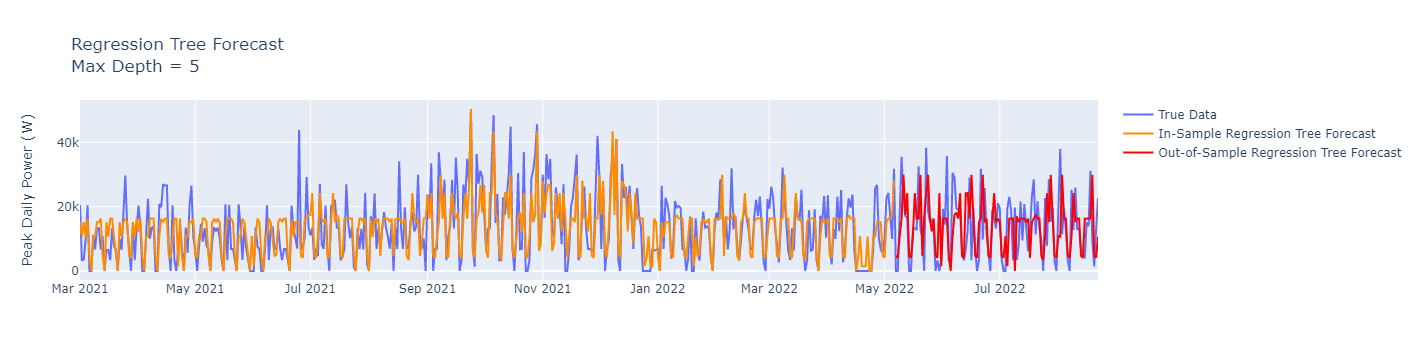

Train Set RMSE: 6926.535936663573 Watts
Test Set RMSE: 10281.274858386989 Watts


In [448]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x = df_24h_tree.index , y = df_24h_tree["max_power"], name = "True Data")
)
fig.add_trace(
    go.Scatter(x = X_train.index, y = regressor.predict(X_train) , name = "In-Sample Regression Tree Forecast" , line= {"color":"#FF8C00"})
)
fig.add_trace(
    go.Scatter(x = X_test.index,
               y = dtree_test_predictions, name = "Out-of-Sample Regression Tree Forecast" , line= {"color":"Red"})
)
fig.update_layout({"title" : "Regression Tree Forecast<br>Max Depth = 5" , "yaxis_title" : "Peak Daily Power (W)"})
fig.show()
print(f'Train Set RMSE: {np.sqrt(np.mean((Y_train - regressor.predict(X_train))**2))} Watts')
print(f'Test Set RMSE: {np.sqrt(np.mean((Y_test - dtree_test_predictions)**2))} Watts')

#### Residuals

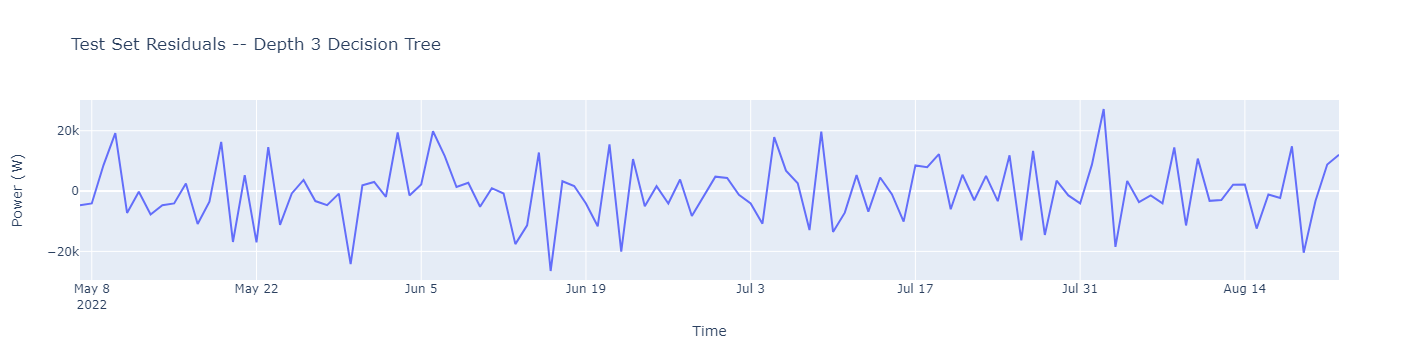

Residual Mean: -259.2275680884405
Residual STD: 10278.006313563115


In [449]:
residuals_df_tree = Y_test - dtree_test_predictions
fig = go.Figure()
fig.add_trace(
    go.Scatter(x = residuals_df_tree.index,
               y = residuals_df_tree)
)
fig.update_layout(title = f"Test Set Residuals -- Depth 3 Decision Tree", xaxis_title = "Time", yaxis_title = "Power (W)")
fig.show()
print("Residual Mean:", np.mean(residuals_df_tree))
print("Residual STD:", np.std(residuals_df_tree))

#### Tree Visualization

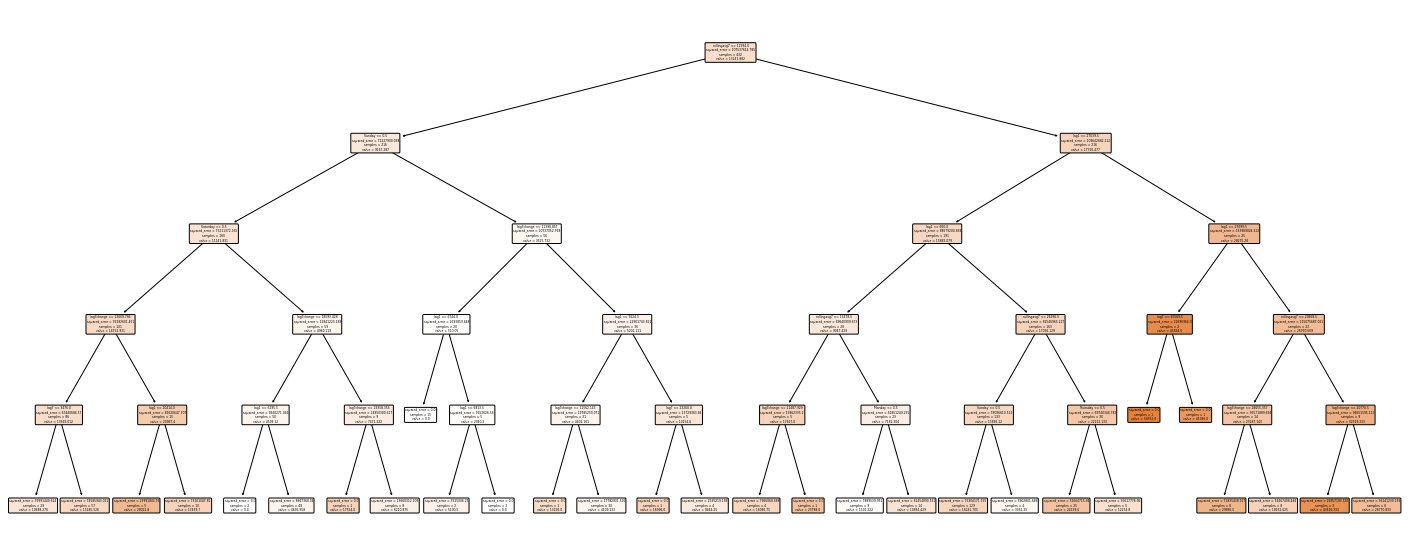

In [450]:
from sklearn import tree

fig = plt.figure(figsize = (25,10))
tree.plot_tree(regressor, feature_names=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday", 
                    "Federal Holiday", "Academic Break", "lag1", "lag7", "rollingavg7", "lag7change"], filled= True, rounded=True)

plt.show()

### Pruning Regression Trees

Above, we manually selected the tree depth to avoid overfitting; alternatively, we allow the tree to grow to large, then remove splits that don't improve the performance of the model.

This usually works better than limiting tree growth because splits that don't make progress are often followed by splits that make a lot of progress. Stunting tree depth beforehand can make it impossible to find these effective, later splits (Shewchuck 82).

In [ ]:
# Create regressor object
regressor = DecisionTreeRegressor(max_depth = 5)

# Fit and predict model
regressor.fit(X_train, Y_train)

dtree_test_predictions = regressor.predict(X_test)

## Appendix

An ARIMA model follows the form of $\mathbf{ARIMA}(p, d, q)x(P, D, Q)_{m}:$ 

Since data separated by seasons may exhibit $\mathbf{AR}$, $\mathbf{MA}$, $\mathbf{ARMA}$, etc., properties the same way consecutive data might, $P, D, Q$ represents the same as their lower case siblings, but refers to the seasonal component of the time series.

| ARIMA Acronym | Parameters                                  |                                                        |
|---------------|---------------------------------------------|--------------------------------------------------------|
| $AR$          | $p$ = order of autoregressive component     | $P$ = order of autoregressive component (seasonal)     |
| $I$           | $d$ = degree of first differencing involved | $D$ = degree of first seasonal differencing involved   |
| $MA$          | $q$ = order of the moving average component | $Q$ = order of the moving average component (seasonal) |
|               | $m$ = number of datapoints per season       |                                                        |

One useful notation in ARIMA models is the backshift operator, $B$. 

$BY_{t} = Y_{t-1}$, and $B(BY_{t}) = B^{2}Y_{t} = Y_{t-2}$, etc. 

Differencing can also be written in terms of backshift operators: 

A first difference can be stated as $Y'_{t} = Y_{t} - Y_{t-1} = Y_{t} - BY_{t} = (1 - B)Y_{t}$.

A second order difference can be stated as $Y''_{t} = Y'_{t} - Y'_{t-1} = (Y_{t} - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_{t} - 2Y_{t-1} + Y_{t-2} = (1-2B+B^{2})Y_{t} = (1 - B)^{2}Y_{t}$, and so on.

It is important to note that a second order difference $(1-B)^{2}$, is not the same as a second difference $1-B^{2}$. A second order difference can be thought of a subtracting each value by the value one time step ago, then subtracting each resultant time step by its last time step again, similar to a second derivative. A second difference results from subtracting each value by the value two time steps ago.

For example, an $\mathbf{ARIMA}(1, 0, 1)x(0, 0, 0)_{1}$ model (also known as an $\mathbf{ARMA}$ model), is defined by the equation:

$Y_{t} = c + \phi_{1}Y_{t-1} - \theta_{1}e_{t-1} + e_{t}$ 

We can see here that we use one time step ago's value and one time step ago's residual to predict the next time step. The order of the $\mathbf{MA}$ or $\mathbf{AR}$ component represents the number of lagged (previous) values to determine the next value.
